# DECOMON tutorial #1
## Bounding the sinus function approximation

## Introduction

After training a model, we want to make sure that the model will give the same output for any images "close" to the initial one, showing some robustness to perturbation. 

In this notebook, we use a simple sinus function as the reference model we want to approximate with a Neural Network. 
The objective is to have a formal proof that outputs of the neural network will not go to weird values. 

In the first part of the notebook, we define the reference function, build a training and test dataset and learn a dense fully connected neural network to approximate this reference function. 

In the second part of the notebook, we build a monotonic decomposition of the learnt model to compute guaranteed bounds to the output of the model.  

What we will show is how decomon module is able to provide guaranteed bounds that ensure our approximation will never have a strange behaviour between test dataset points. 

## The notebook

### imports

In [1]:
import os
import tensorflow.keras as keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, Activation, Reshape, \
Conv2D, Add, Flatten, Dense, Layer, MaxPooling2D, Subtract, Concatenate, Multiply, Add, Subtract
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
print('Notebook run using keras:', keras.__version__)
import sys
sys.path.append('..')

Notebook run using keras: 2.4.0


### Build and Train a Neural Network on a sinusoide

The sinusoide funtion is defined on a $[-1 ; 1 ]$ interval. We put a factor in the sinusoide to have several periods of oscillations. 


In [2]:
x = np.linspace(-1, 1, 1000)
y = np.sin(10*x)

We approximate this funciton by a fully connected network composed of 4 hidden layers of size 100, 100, 20 and 20 respectively. Rectified Linear Units (ReLU) are chosen as activation functions for all the neurons. 

In [3]:
layers = []
layers.append(Dense(100, activation='relu', input_dim=1)) # specify the dimension of the input space
layers.append(Dense(100, activation='relu'))
layers.append(Dense(20, activation='relu'))
layers.append(Dense(20, activation='relu'))
layers.append(Dense(1, activation='linear'))
model = Sequential(layers)

we specify the optimization method and the metric, in this case a classical Means Square Error. 

In [4]:
model.compile('adam', 'mse')

we train the neural network

In [5]:
model.fit(x, y, batch_size=32, shuffle=True, epochs=100, verbose=0) 
# verbose=0 removes the printing along the training

we can now display the output of our neural network on a more refined grid. 

In [6]:
x_test = np.linspace(-1, 1, 2000)
y_pred = model.predict(x_test)

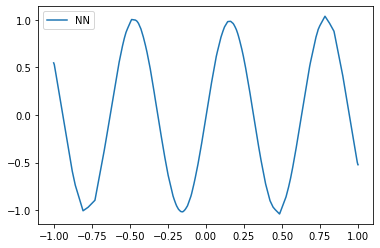

In [7]:
plt.plot(x_test, y_pred)
plt.legend(['NN'])

It looks reasonably as a sinus function and nothing crazy is happening. Still, are we able to ensure that between a finer grid, there will not be a point where the learnt model will not output a crazy output? The answer is in general no, we cannot. And this is more and more true when the complexity of the model is increasing. 

Fortunately, decomon allows to find rigorous bounds of the model that will be true on the full input domain definition. 

<img src="./data/decomon.jpg" alt="Decomon!" width="400"/>

### applying decomon

In [8]:
import decomon

In [9]:
import tensorflow

In [10]:
from decomon.models import convert
from decomon import get_upper_box, get_lower_box, get_range_box

First, we can compute global constant upper and lower bounds that hold for the whole interval [-1, 1]

In [11]:
# convert our model into a decomon model:
decomon_model = convert(model)

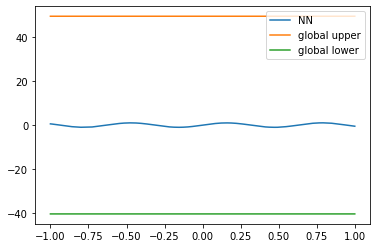

In [12]:
X_min = np.array([x.min()])
X_max = np.array([x.max()])

global_upper = get_upper_box(decomon_model, X_min, X_max, fast=False)
global_lower = get_lower_box(decomon_model, X_min, X_max, fast=False)

plt.plot(x_test, y_pred)
plt.plot(x_test, global_upper*np.ones_like(y_pred))
plt.plot(x_test, global_lower*np.ones_like(y_pred))
plt.legend(['NN', 'global upper', 'global lower'])

In a tighter region, the bounds became tighter



In [13]:
# you can play with the interval [x_min, x_max]
x_min = -0.25
x_max = 0.25
X_min = np.array([x_min])
X_max = np.array([x_max])

refine_upper, refine_lower = get_range_box(decomon_model, X_min, X_max)

print('if {}<= x <= {}, we can ensure that {} <= NN(x) <= {}'.format(x_min, x_max, refine_lower, refine_upper))

if -0.25<= x <= 0.25, we can ensure that [[-9.94911623]] <= NN(x) <= [[13.75945199]]


In this one line of code, taking as input the trained model, a model implementing the monotonic decomposition is built. Taking advantage of the increasingness and decreasingness of the two functions into which we have decomposed our learnt model, we are able to derive rigorous bounds on each part of the input space.  

In [14]:
def func(min_value=-1., max_value=1., n_step=300):
    
    if min_value>max_value:
        print('Error min_value={} >max_value={}. Reset the demo to the whole domain'.format(min_value, max_value))
        min_value=-1
        max_value=1.
    samples = np.linspace(min_value, max_value, n_step)
    
    upper = get_upper_box(decomon_model,samples[:-1], samples[1:])
    lower = get_lower_box(decomon_model,samples[:-1], samples[1:])
    
    y_samples = model.predict(samples)

    x_ =[]
    upper_=[]
    lower_=[]

    # lower and upper bounds are step function
    for i in range(n_step-1):
        x_.append(samples[i])
        x_.append(samples[i+1])
        upper_.append(upper[i])
        upper_.append(upper[i])
        lower_.append(lower[i])
        lower_.append(lower[i])
        
    ##########
    n_cols = 2
    fig, axs = plt.subplots(n_cols)
    fig.set_figheight(n_cols*fig.get_figheight())
    fig.set_figwidth(n_cols*fig.get_figwidth())
    plt.subplots_adjust(hspace=0.2)  # increase vertical separation
    axs_seq = axs.ravel()

    ax= axs[0]
    ax.plot(x_test, y_pred)
    ax.plot(samples, y_samples, 'x', c='k')
    ax.legend(['NN'])
    ax.set_title('Sampling n_step={}'.format(n_step))
    
    ax= axs[1]
    ax.plot(samples, y_samples)
    ax.plot(samples, y_samples, 'x', c='k')
    ax.plot(x_, upper_, c='purple')
    ax.plot(x_, lower_, c='orange')
    ax.legend(['NN', 'upper', 'lower'])
    ax.set_title('Bounding the prediction of the neural network')

In [15]:
interact(func, n_step = widgets.IntSlider(value=0,
                                               min=5,
                                               max=100,
                                               step=1, continuous_update=False),
        min_value = widgets.FloatSlider(value=-1,
                                               min=-1,
                                               max=1.,
                                               step=0.01, continuous_update=False),
        max_value = widgets.FloatSlider(value=1,
                                               min=-1,
                                               max=1,
                                               step=0.01, continuous_update=False),
        )

interactive(children=(FloatSlider(value=-1.0, continuous_update=False, description='min_value', max=1.0, min=-…

<function __main__.func(min_value=-1.0, max_value=1.0, n_step=300)>

In the previous interactive graph, you can set:
- n_step: the number of intervals on which we divide the input space to improve the bounds deduced from the monotonic decomposition
- min_value: the minimun value of the interval
- max_value: the maximum value of the interval

The graphs below show you:
- the trained model with sample values drawn with the n_step discretization of the $[min_value ; max_value]$ interval
- the increasing and decreasing function on each local interval and in dashed the increasing and decreasing function computed on the whole interval
- the bounds computed with the monotonic decomposition on the n_step intervals
- the increasing and decreasing function on each local interval 

Increasing the number of n_step allows to have tighter bounds. Hopefully, this number will keep reasonable for your preferred model!

Enjoy!